# L2-B - Linear Quantization I: Get the Scale and Zero Point

In this lesson, continue to learn about fundamentals of linear quantization, and implement your own Linear Quantizer.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Linear Quantization I` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [1]:
import torch

from helper import linear_q_with_scale_and_zero_point, linear_dequantization, plot_quantization_errors

### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

## Finding `Scale` and `Zero Point` for Quantization

In [3]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [4]:
q_min

-128

In [5]:
q_max

127

In [6]:
# r_min = test_tensor.min()
r_min = test_tensor.min().item()

In [7]:
r_min

-184.0

In [8]:
r_max = test_tensor.max().item()

In [9]:
r_max

728.5999755859375

In [10]:
scale = (r_max - r_min) / (q_max - q_min)

In [11]:
scale

3.578823433670343

In [12]:
zero_point = q_min - (r_min / scale)

In [13]:
zero_point

-76.58645490333825

In [14]:
zero_point = int(round(zero_point))

In [15]:
zero_point

-77

- Now, put all of this in a function.

## Scale and Zero Point

Linear quantization maps the floating point range $[r_{\min}, r_{\max}]$ to the quantized range $[q_{\min}, q_{\max}]$

If we look at the **extreme values**, we should get:

$$
\begin{cases} 
r_{\min} = s (q_{\min} - z) \\
r_{\max} = s (q_{\max} - z)
\end{cases}
$$

If we subtract the first equation from the second one, we get the **scale** $s$:

$$
s = \frac{(r_{\max} - r_{\min})}{(q_{\max} - q_{\min})}
$$

For the **zero point** $z$, we need to round the value since it is an $n$-bit integer:

$$
z = \text{int} \left( \text{round} \left( q_{\min} - \frac{r_{\min}}{s} \right) \right)
$$


### (Optional) Scale Derivation

$$
\begin{cases} 
r_{\min} = s(q_{\min} - z) \\
r_{\max} = s(q_{\max} - z)
\end{cases}
$$

$$r_{\min} - r_{\max} = s(q_{\min} - z) - s(q_{\max} - z)$$

$$= s \left( (q_{\min} - z) - (q_{\max} - z) \right)$$

$$= s \left( (q_{\min} - q_{\max} - z + z) \right)$$

$$= s (q_{\min} - q_{\max})$$

$$\frac{r_{\min} - r_{\max}}{q_{\min} - q_{\max}} = s$$

### (Optional) Zero Point Derivation

$$
\begin{cases} 
r_{\min} = s(q_{\min} - z) \\
r_{\max} = s(q_{\max} - z)
\end{cases}
$$

$$r_{\min} = s(q_{\min} - z)$$

$$r_{\min} = s q_{\min} - s z$$

$$s z = s q_{\min} - r_{\min}$$

$$z = \frac{s q_{\min} - r_{\min}}{s}$$

$$z = q_{\min} - \frac{r_{\min}}{s}$$

$$z = \text{int} \left( \text{round} \left( q_{\min} - \frac{r_{\min}}{s} \right) \right)$$


In [16]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)

    zero_point = q_min - (r_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    
    return scale, zero_point

- Test the implementation using the `test_tensor` defined earlier.
```Python
[[191.6, -13.5, 728.6],
 [92.14, 295.5,  -184],
 [0,     684.6, 245.5]]
```

In [17]:
new_scale, new_zero_point = get_q_scale_and_zero_point(
    test_tensor)

In [18]:
new_scale

3.578823433670343

In [19]:
new_zero_point

-77

## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

- Use the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [20]:
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, new_scale, new_zero_point)

In [21]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           new_scale, new_zero_point)

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

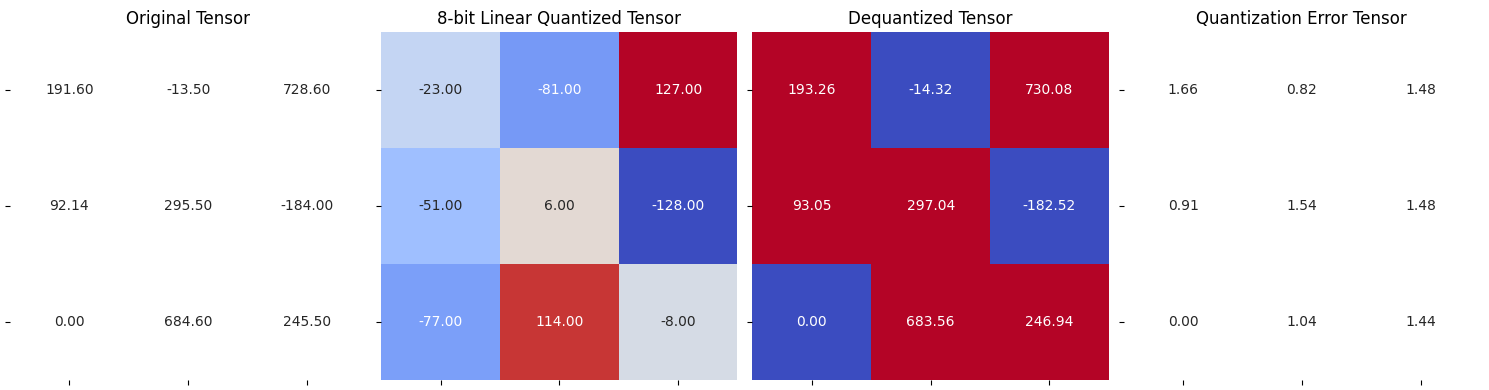

In [22]:
plot_quantization_errors(test_tensor, quantized_tensor, 
                         dequantized_tensor)

In [23]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [25]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, 
                                                   dtype=dtype)
    
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                          scale, 
                                                          zero_point, 
                                                          dtype=dtype)
    
    return quantized_tensor, scale , zero_point

- Test your implementation on a random matrix.

In [26]:
r_tensor = torch.randn((4, 4))

**Note:** Since the values are random, what you see in the video might be different than what you will get.

In [27]:
r_tensor

tensor([[ 0.4259,  0.4345, -0.7652,  0.7941],
        [ 0.2357, -0.5532, -1.1529,  1.9366],
        [ 0.5518, -0.3398,  0.8595, -1.1166],
        [-1.3829, -0.5637, -0.3474,  2.2474]])

In [28]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [29]:
quantized_tensor

tensor([[  -1,    0,  -85,   25],
        [ -14,  -70, -112,  105],
        [   8,  -55,   29, -109],
        [-128,  -71,  -55,  127]], dtype=torch.int8)

In [30]:
scale

0.01423623935849059

In [31]:
zero_point

-31

In [32]:
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           scale, zero_point)

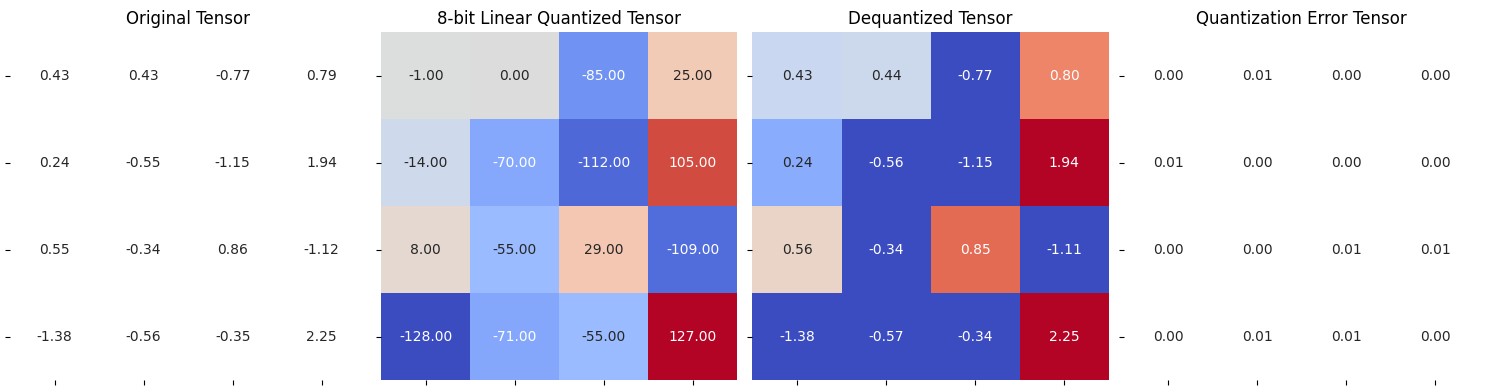

In [33]:
plot_quantization_errors(r_tensor, quantized_tensor,
                         dequantized_tensor)

In [34]:
(dequantized_tensor-r_tensor).square().mean()

tensor(1.6904e-05)